In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.preprocessing import *
from sklearn.impute import *

import json
import joblib

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = compute_features(df.drop('mortality',axis=1))
y = df.mortality.values



In [4]:
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

with open('probit.json','r') as f:
    probit_param = json.load(f)
with open('logistic.json','r') as f:
    logistic_param = json.load(f)

print(probit_param)
print(logistic_param)
    

{'l1': 0.002988761334869139, 'l2': 0.01946744944027845, 'n_neighbors': 19.65784708642015}
{'l1': 0.006319412388809065, 'l2': 0.22351135718523918, 'n_neighbors': 19.31685834937781}


# Probit Model

In [5]:
probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(probit_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(probit_param['n_neighbors']))),
]

probit_pipeline = Pipeline(probit_pipeline)
probit_x = probit_pipeline.fit_transform(x)
probit = probitModel(l1=probit_param['l1'], l2=probit_param['l2'], w=0.75)

res_dict = probit.fit(probit_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']

Current loss: 0.780911643530707
Current loss: 0.7218579832603499
Current loss: 0.568392521344703
Current loss: 0.4921731137664971
Current loss: 0.48632634770033895
Current loss: 0.4856503184244249
Current loss: 0.4848497597905866
Current loss: 0.48465697546454606
Current loss: 0.48443947757382105
Current loss: 0.48419726994792317
Current loss: 0.4841450595499449
Current loss: 0.48406085581962494
Current loss: 0.48410861740638916
Current loss: 0.4841590181997808
Current loss: 0.4840519042748961
Current loss: 0.48402304797052503
Current loss: 0.4840586096848625
Current loss: 0.4840794827806947
Current loss: 0.4840194967135238
Current loss: 0.48403901390742166
Current loss: 0.48408249193913094
Current loss: 0.4840428109333955
Current loss: 0.48396993241576824
Current loss: 0.48428275219752603
Current loss: 0.4840129132231393
Current loss: 0.48399039478166006
Current loss: 0.48397314748012477
Current loss: 0.4839927485659408
Optimization result: Optimization terminated successfully
Wald te

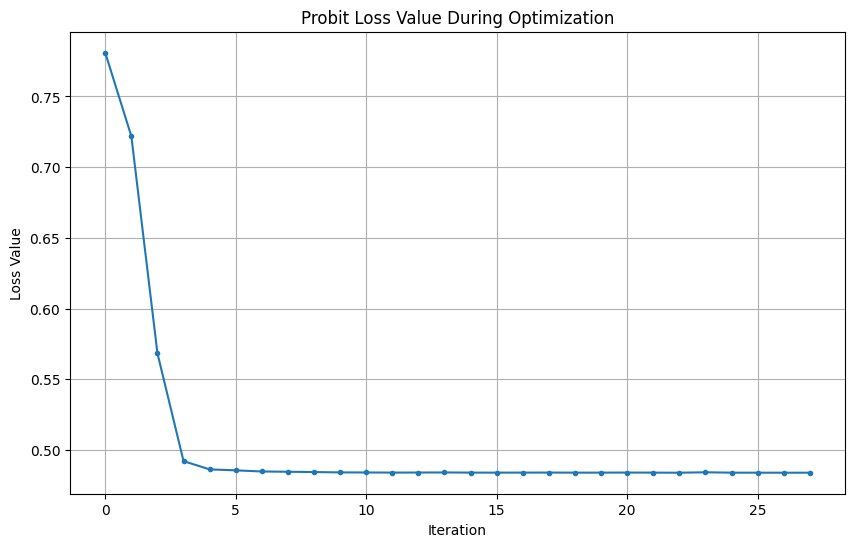

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [7]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# show top 5 important features
wald_res.head(5)


,feature,coef,std err,z,P>|z|
0,Oxygen saturation_min,-0.069175,0.0332,-2.0858,0.0370
1,is_outlier,-0.098971,0.0593,-1.6695,0.0950
2,Respiratory rate_mean,0.109642,0.0866,1.2661,0.2055
3,Temperature_mean,-0.096601,0.0798,-1.2100,0.2263
4,Temperature_min,-0.054197,0.0526,-1.0303,0.3029


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higer is_outlier (1 for inliner, -1 for outlier) decrease mortality risk (outlier higher risk)
- Higher Respiratory rate_mean increases mortality risk
- Higher Temperature_mean decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)


## Saving the model

In [8]:
joblib.dump(probit_pipeline, 'probit_pipeline.pkl')
joblib.dump(probit, 'probit.pkl')

['probit.pkl']

# Logistic Model

In [9]:
logistic_pipeline = base_pipeline + [ #
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(logistic_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(logistic_param['n_neighbors']))),
]
logistic_pipeline = Pipeline(logistic_pipeline)
logistic_x = logistic_pipeline.fit_transform(x)
logistic = logisticModel(l1=logistic_param['l1'], l2=logistic_param['l2'], w=0.75)

res_dict = logistic.fit(logistic_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']


Current loss: 1.6105141586389136
Current loss: 0.575147474355807
Current loss: 0.5264671544742917
Current loss: 0.5263903328523487
Current loss: 0.525336020312307
Optimization result: Optimization terminated successfully
Wald test summary:
+----+---------+--------------+-----------+---------+---------+
|    |   index |         coef |   std err |       z |   P>|z| |
|----+---------+--------------+-----------+---------+---------|
|  0 |      31 | -0.00161737  |    0.0298 | -0.0543 |  0.9567 |
|  1 |      19 | -0.00184602  |    0.0515 | -0.0358 |  0.9714 |
|  2 |      65 |  0.00276538  |    0.1149 |  0.0241 |  0.9808 |
|  3 |      25 | -0.00156226  |    0.0809 | -0.0193 |  0.9846 |
|  4 |      16 | -0.0019133   |    0.1128 | -0.017  |  0.9865 |
|  5 |      21 |  0.00220378  |    0.1354 |  0.0163 |  0.987  |
|  6 |      64 | -0.00307014  |    0.1892 | -0.0162 |  0.9871 |
|  7 |      40 |  0.00109058  |    0.0869 |  0.0126 |  0.99   |
|  8 |      10 | -0.00130849  |    0.1054 | -0.0124 |  0

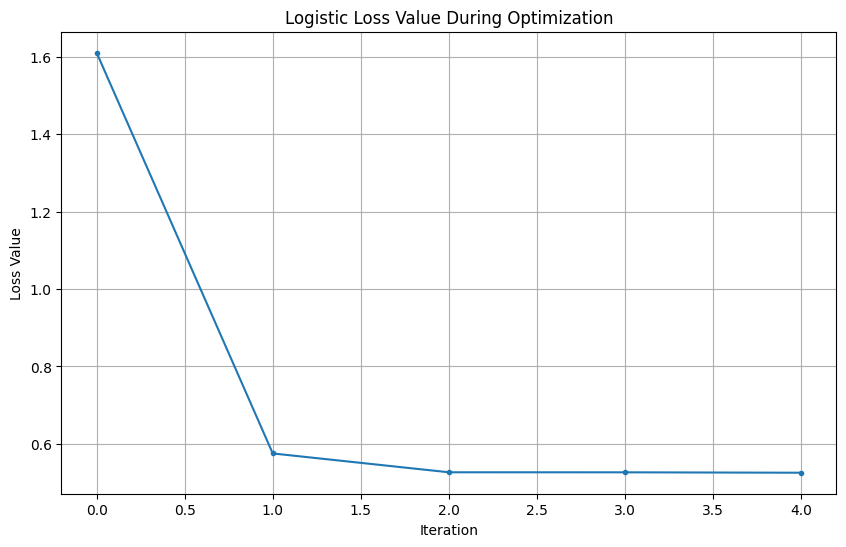

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [11]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# show top 5 important features
wald_res.head(5)


,feature,coef,std err,z,P>|z|
0,pH_min,-0.001617,0.0298,-0.0543,0.9567
1,Oxygen saturation_min,-0.001846,0.0515,-0.0358,0.9714
2,pH_max_to_mean,0.002765,0.1149,0.0241,0.9808
3,Temperature_min,-0.001562,0.0809,-0.0193,0.9846
4,Systolic blood pressure_min,-0.001913,0.1128,-0.0170,0.9865


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk




## Saving the model

In [12]:
joblib.dump(logistic_pipeline, 'logistic_pipeline.pkl')
joblib.dump(logistic, 'logistic.pkl')

['logistic.pkl']